In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
df = pd.read_excel('RC_Shear_Wall_Database_20240514.xlsx')
print("Initial data preview:")
print(df.head())

Initial data preview:
   Num                Author Specimen  FailureMode      τ/fc  Drift_at_yield  \
0  1.0  Lefas et al. (1990a)     SW11            1  0.094692        0.006061   
1  2.0  Lefas et al. (1990a)     SW12            1  0.120824        0.007273   
2  3.0  Lefas et al. (1990a)     SW13            1  0.154821        0.006061   
3  4.0  Lefas et al. (1990a)     SW14            1  0.119896        0.007273   
4  5.0  Lefas et al. (1990a)     SW15            1  0.140768        0.007273   

   Drift_at_Max        θu  M/Vlw      lw/tw  ...  Moment32  Moment33  \
0      0.009697  0.010000    1.1  10.714286  ...       NaN       NaN   
1      0.010909  0.010739    1.1  10.714286  ...       NaN       NaN   
2      0.012121  0.010764    1.1  10.714286  ...       NaN       NaN   
3      0.012121  0.013588    1.1  10.714286  ...       NaN       NaN   
4      0.010909  0.009758    1.1  10.714286  ...       NaN       NaN   

   Moment34  Moment35  Moment36 Moment37  Moment38  Moment39  Mo

In [2]:
# Step 2: Remove missing values
missing_rate = df.isnull().mean()
# Filter out columns with a missing rate of less than 5% and retain these columns
df_filtered = df.loc[:, missing_rate <= 0.05]
print("Retain attributes that are missing less than 5%：", df_filtered.columns.tolist())

Retain attributes that are missing less than 5%： ['Author', 'Specimen', 'FailureMode', 'τ/fc', 'θu', 'M/Vlw', 'lw/tw', 'ρvwFy,vw/fc', 'ρhwFy,vw/fc', 'ρvcFy,vc/fc', 'ρhcFy,hc/fc', 'P/fcAg', 'Section', 'Ab/Ag', 'Vtest/Ag/sqrt(fc)', 'V@M/Vn_GB', 'V@M/Vn_ACI', 'V@M/Vtest', 'Vn_GB/Vtest', 'Vn_ACI/Vtest', 'Vtest', 'Vn_ACI', 'Vn_GB', 'alpha_c', 'lamda', 'N', 'Vc', 'Vs', 'P', 'fc', 'ft', 'alpha1', 'beta1', 'lw', "as'", 'lw0', 'tw', 'h', 'Aw', 'A', 'Ag', 'Fy,hw', 'Fy,vw', 'Fy,vc', 'ρvw', 'ρhw', 'V@moment', 'ForceEquilibrium', 'Moment', 'x_real', 'eps_cu', 'Ec', 'Es', 'DRein.1', 'DRein.2', 'DRein.3', 'DRein.4', 'DRein.5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'Force1', 'Force2', 'Force3', 'Force4', 'Force5', 'Moment1', 'Moment2', 'Moment3', 'Moment4', 'Moment5', 'No']


In [3]:
cols_with_missing = df_filtered.columns[df_filtered.isnull().any()]
print("Columns that still contain missing values：", cols_with_missing.tolist())

Columns that still contain missing values： ['DRein.5', 'Area5', 'Force5', 'Moment5']


In [4]:
df = df_filtered.drop(columns=['Author', 'Specimen','No','DRein.5', 'Area5', 'Force5', 'Moment5'])

In [5]:
print(df.isnull().sum())

FailureMode    0
τ/fc           0
θu             0
M/Vlw          0
lw/tw          0
              ..
Force4         0
Moment1        0
Moment2        0
Moment3        0
Moment4        0
Length: 67, dtype: int64


In [6]:
df.to_csv('processed_dataset.csv', index=True)

Training set original class distribution： Counter({3: 150, 1: 146, 2: 24, 4: 23})


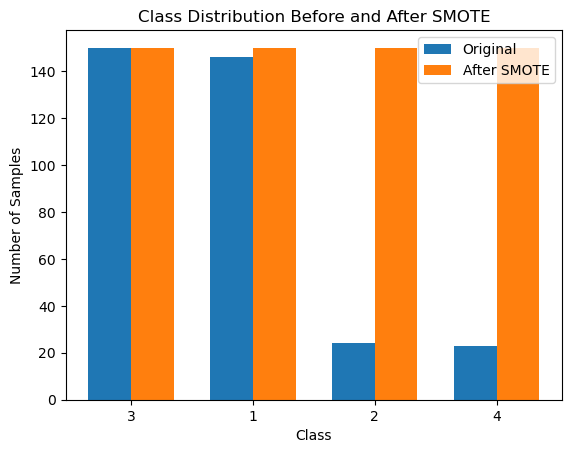

Training set class distribution after SMOTE： Counter({3: 150, 1: 150, 2: 150, 4: 150})
Training set after PCA: (600, 21)
Test set after PCA: (86, 21)


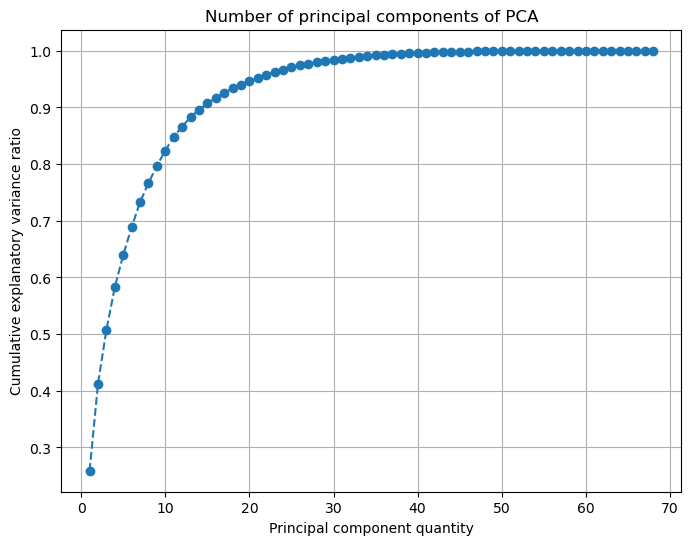

In [17]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
df_processed = pd.read_csv('processed_dataset.csv')
#print(df_processed.head(5))

df_processed = pd.get_dummies(df_processed, columns=['Section'], drop_first=True)

X = df_processed.drop(columns=['FailureMode'])
y = df_processed['FailureMode']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set original class distribution：", Counter(y_train))
orig_counts = Counter(y_train)
resampled_counts = Counter(y_train_res)

classes = list(orig_counts.keys())
orig_values = [orig_counts[k] for k in classes]
resampled_values = [resampled_counts[k] for k in classes]

x_pos = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_pos - width/2, orig_values, width, label='Original')
rects2 = ax.bar(x_pos + width/2, resampled_values, width, label='After SMOTE')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Before and After SMOTE')
ax.set_xticks(x_pos)
ax.set_xticklabels(classes)
ax.legend()
plt.show()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after SMOTE：", Counter(y_train_res))

# Apply PCA after SMOTE 
pca = PCA(n_components=0.95, random_state=42)
X_train_res_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test_scaled)

print("Training set after PCA:", X_train_res_pca.shape)
print("Test set after PCA:", X_test_pca.shape)

pca_full = PCA()
pca_full.fit(X_train_res)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Principal component quantity')
plt.ylabel('Cumulative explanatory variance ratio')
plt.title('Number of principal components of PCA')
plt.grid(True)
plt.show()